# Projeto Credit Scoring para Cartão de Crédito 

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
import warnings

from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.decomposition import PCA
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from pycaret.classification import *

from scipy.stats import t, ks_2samp

sns.set_palette('colorblind')

%matplotlib inline

#### Definição das Funções

In [9]:
def IV(variavel, resposta):
    tab = pd.crosstab(variavel, resposta, margins=True, margins_name='total')

    tilo_evento = tab.columns[0]
    tilo_nao_evento = tab.columns[1]

    tab['pct_evento'] = tab[tilo_evento]/tab.loc['total', tilo_evento]
    tab['ep'] = tab[tilo_evento]/tab.loc['total', tilo_evento]

    tab['pct_nao_evento'] = tab[tilo_nao_evento] / tab.loc['total', tilo_nao_evento]
    tab['woe'] = np.log(tab.pct_evento/tab.pct_nao_evento)
    tab['iv_parcial'] = (tab.pct_evento - tab.pct_nao_evento)*tab.woe
    return tab['iv_parcial'].sum()

In [10]:
def biv_discreta(var, df):
    df['bom'] = 1-df.mau
    g = df.groupby(var)

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau': g['mau'].mean(),
                        var: g['mau'].mean().index,
                        'cont': g[var].count()})

    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep

    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    tx_mau_geral = df.mau.mean()
    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    fig, ax = plt.subplots(2, 1, figsize=(8, 6))
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')

    num_cat = biv.shape[0]
    ax[0].set_xlim([-.3, num_cat-.7])

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)

    ax[0].set_xticks(list(range(num_cat)))
    ax[0].set_xticklabels(biv[var], rotation=8)

    ax[1] = biv.cont.plot.bar()
    return biv

In [11]:
def biv_continua(var, ncat, df):
    df['bom'] = 1-df.mau
    cat_srs, bins = pd.qcut(df[var], ncat, retbins=True, precision=0, duplicates='drop')
    g = df.groupby(cat_srs)

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau': g['mau'].mean(),
                        var: g[var].mean(),
                        'cont': g[var].count()})

    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep

    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    tx_mau_geral = df.mau.mean()
    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    fig, ax = plt.subplots(2, 1, figsize=(8, 6))
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')

    num_cat = biv.shape[0]

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)

    ax[1] = biv.cont.plot.bar()
    return None

In [12]:
df = pd.read_feather('credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [13]:
' + '.join(list(df.columns))

'data_ref + index + sexo + posse_de_veiculo + posse_de_imovel + qtd_filhos + tipo_renda + educacao + estado_civil + tipo_residencia + idade + tempo_emprego + qt_pessoas_residencia + renda + mau'

In [14]:
print(df.data_ref.min())
print(df.data_ref.max())

2015-01-01 00:00:00
2016-03-01 00:00:00


#### Separando base treino e teste

In [15]:
df.set_index('data_ref', inplace=True)
df = df.drop('index', axis=1)

df_train = df['2015-01-01':'2015-12-01']
df_test = df['2016-01-01':]

df_train.reset_index(inplace=True)
df_test.reset_index(inplace=True)

df_train['mes'] = df_train['data_ref'].dt.month
warnings.filterwarnings('ignore')

In [16]:
df.head()

,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
data_ref,,,,,,,,,,,,,
2015-01-01,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
2015-01-01,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2015-01-01,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
2015-01-01,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
2015-01-01,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

Text(0.5, 1.0, 'Número de linhas para cada mês da base de treino')

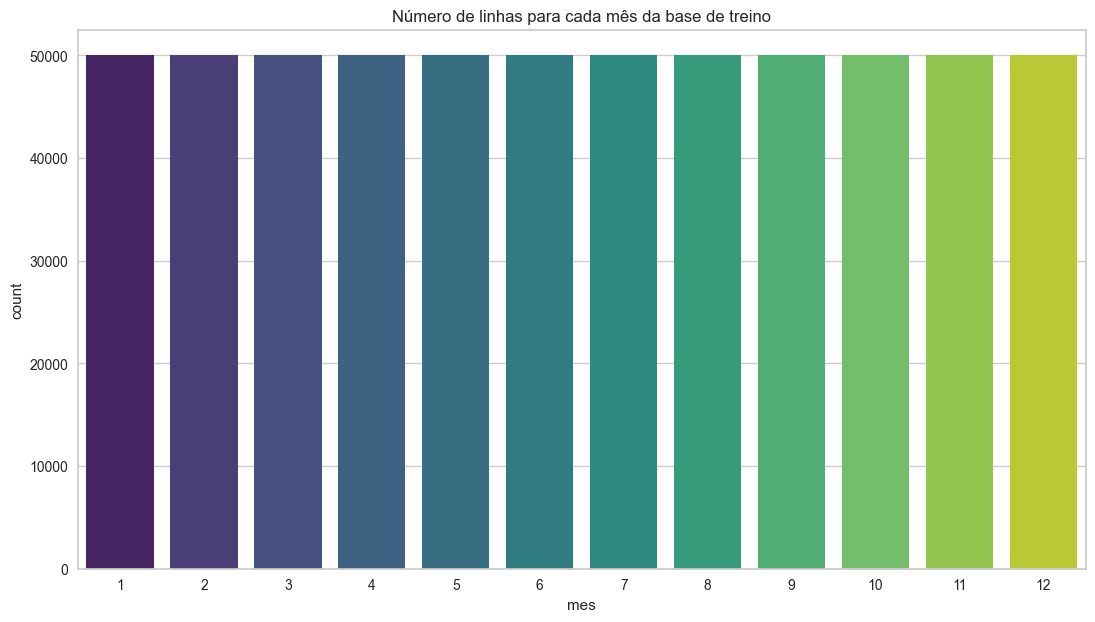

In [17]:
fig, ax = plt.subplots(figsize=(13, 7))
sns.countplot(data=df_train, x='mes', palette='viridis', ax=ax)
ax.set_title('Número de linhas para cada mês da base de treino')

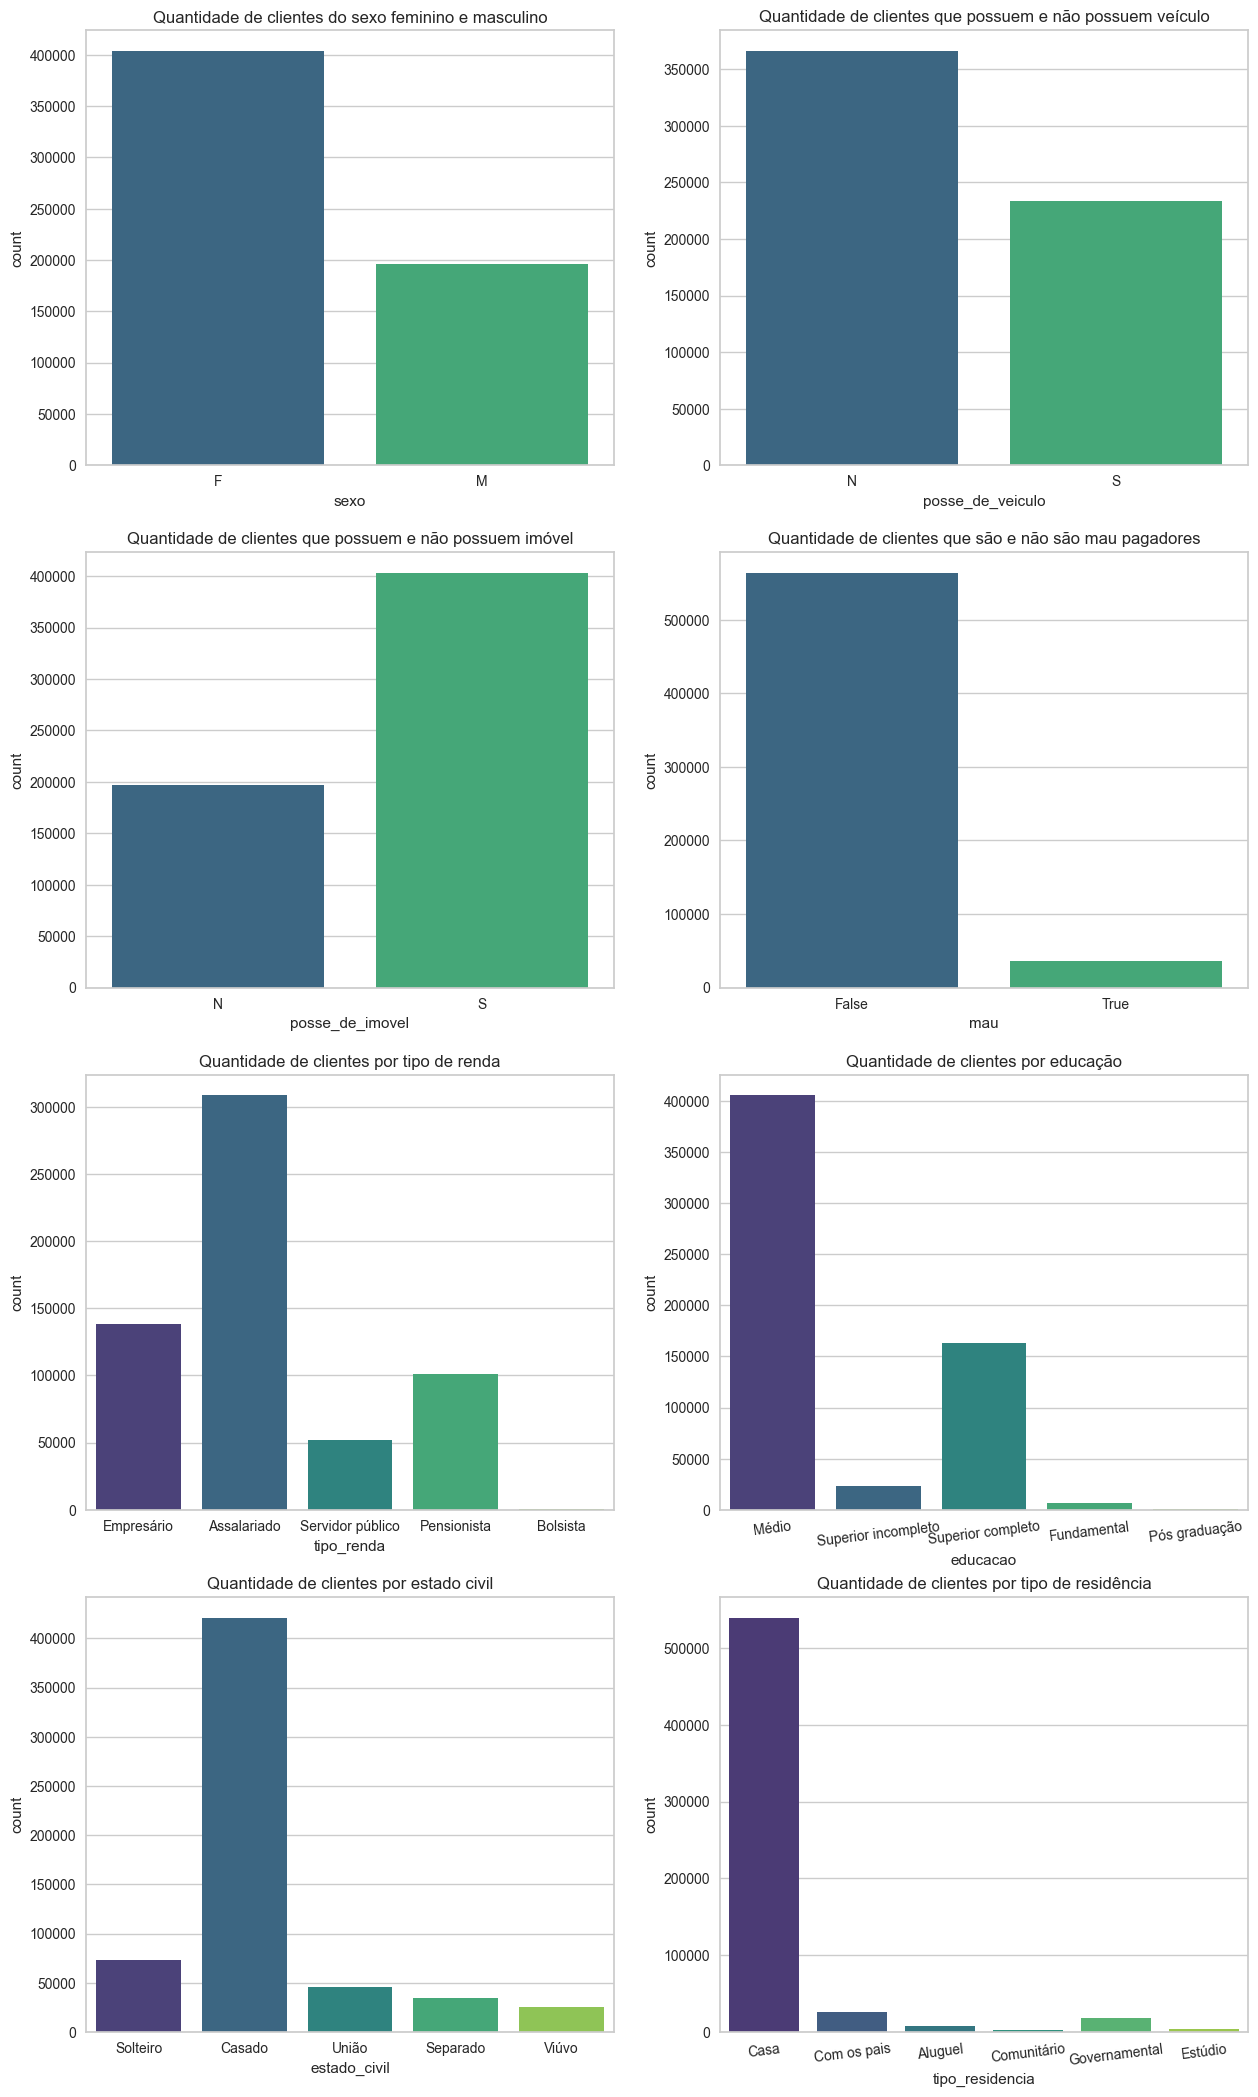

In [18]:
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(15, 26))

sns.countplot(data=df_train, x='sexo', palette='viridis', ax=ax[0, 0])
ax[0, 0].set_title('Quantidade de clientes do sexo feminino e masculino')

sns.countplot(data=df_train, x='posse_de_veiculo', palette='viridis', ax=ax[0, 1])
ax[0, 1].set_title('Quantidade de clientes que possuem e não possuem veículo')

sns.countplot(data=df_train, x='posse_de_imovel', palette='viridis', ax=ax[1, 0])
ax[1, 0].set_title('Quantidade de clientes que possuem e não possuem imóvel')

sns.countplot(data=df_train, x='mau', palette='viridis', ax=ax[1, 1])
ax[1, 1].set_title('Quantidade de clientes que são e não são mau pagadores')

sns.countplot(data=df_train, x='tipo_renda', palette='viridis', ax=ax[2, 0])
ax[2, 0].set_title('Quantidade de clientes por tipo de renda')

sns.countplot(data=df_train, x='educacao', palette='viridis', ax=ax[2, 1])
ax[2, 1].set_title('Quantidade de clientes por educação')
for tick in ax[2, 1].get_xticklabels():
    tick.set_rotation(7)

sns.countplot(data=df_train, x='estado_civil', palette='viridis', ax=ax[3, 0])
ax[3, 0].set_title('Quantidade de clientes por estado civil')

sns.countplot(data=df_train, x='tipo_residencia', palette='viridis', ax=ax[3, 1])
ax[3, 1].set_title('Quantidade de clientes por tipo de residência')
for tick in ax[3, 1].get_xticklabels():
    tick.set_rotation(7)


Text(0.5, 1.0, 'Quantidade de clientes por renda')

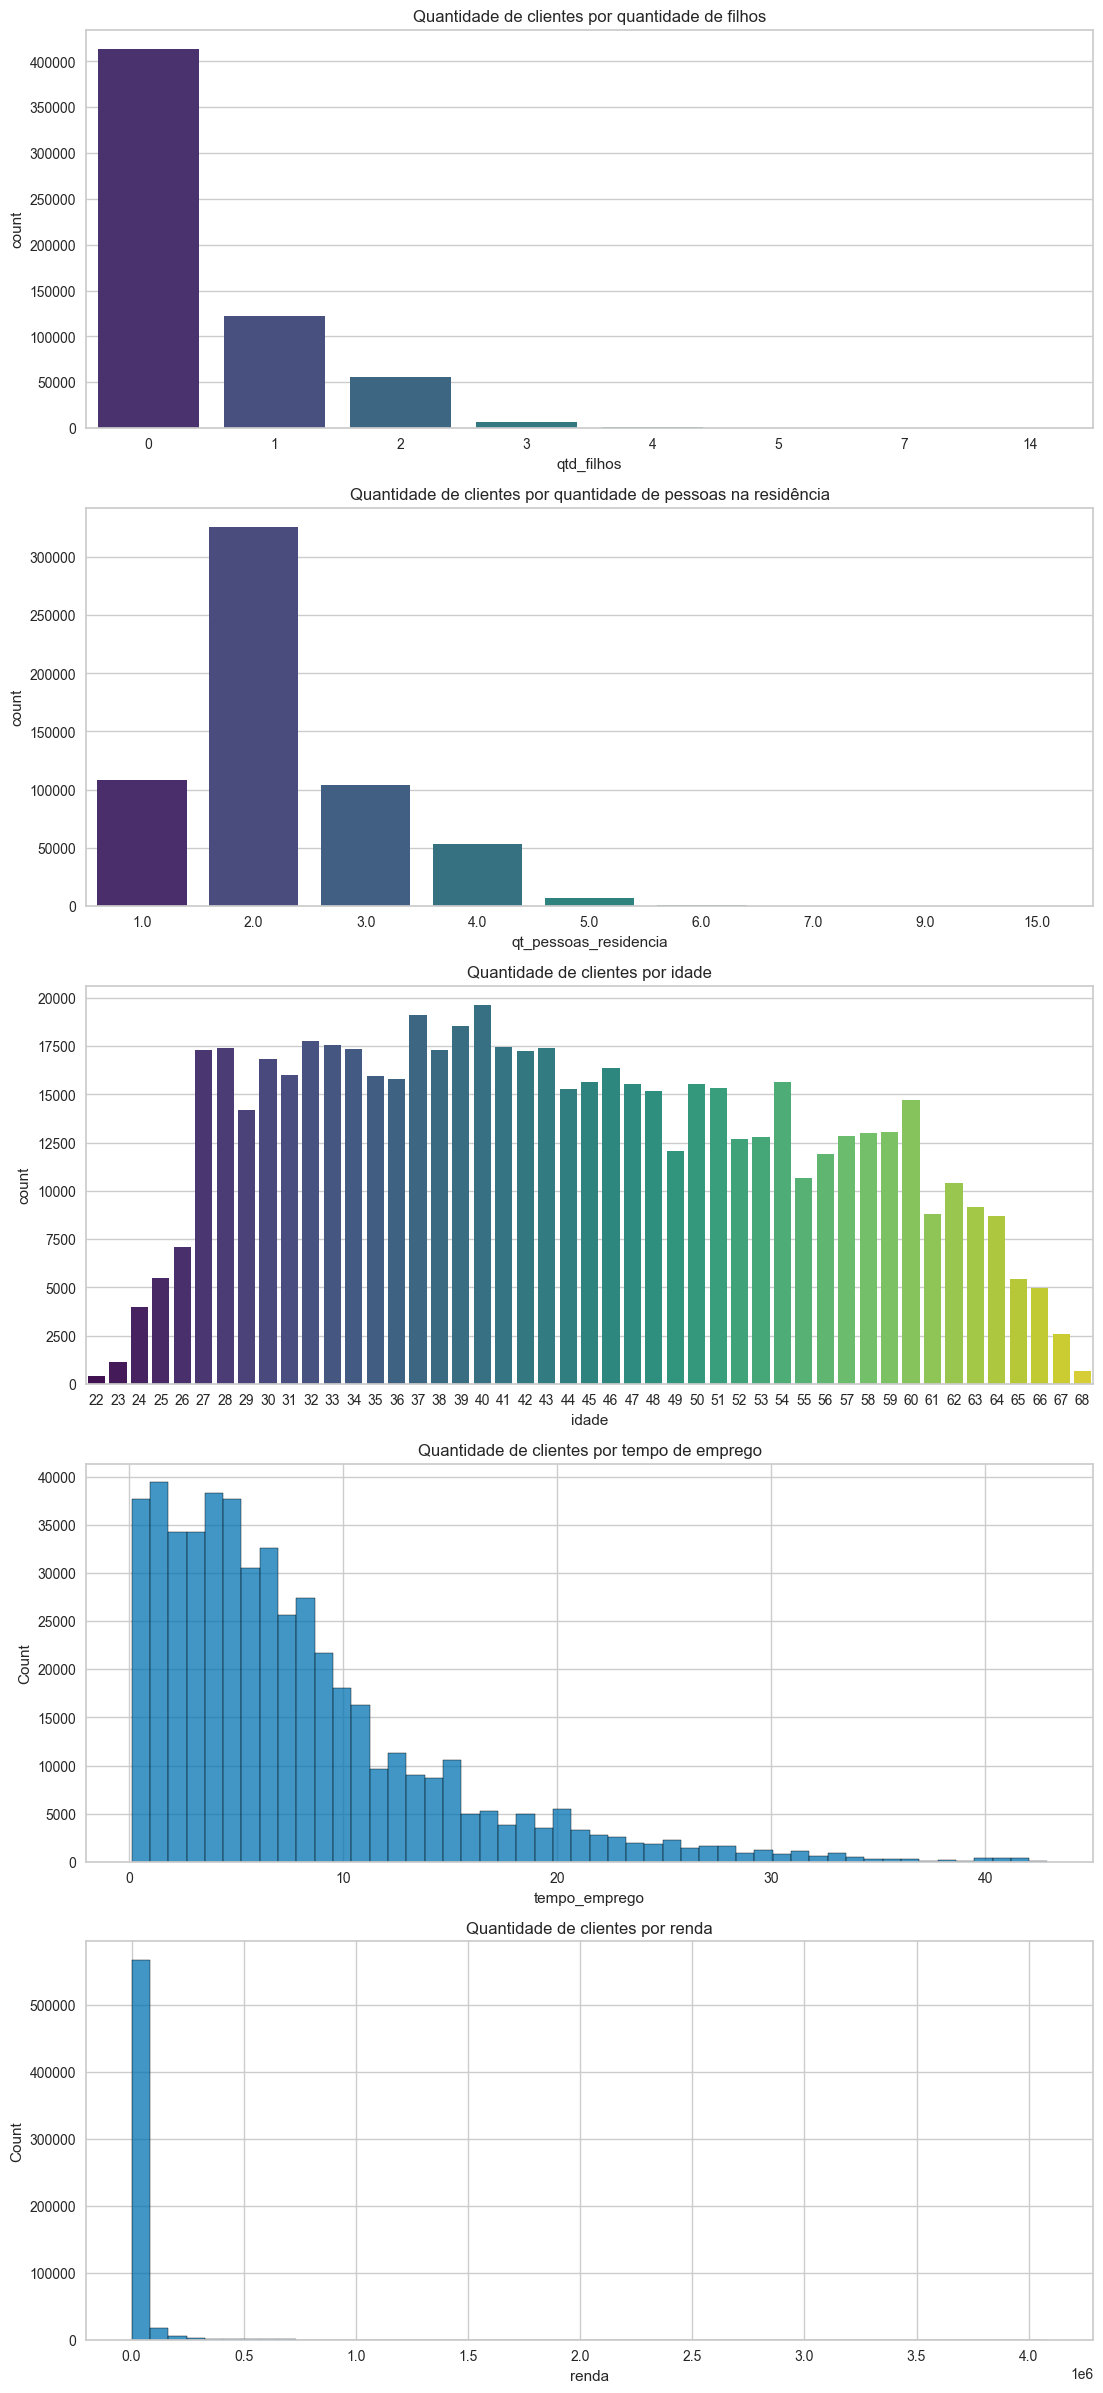

In [19]:
fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(13, 30))

sns.countplot(data=df_train, x='qtd_filhos', palette='viridis', ax=ax[0])
ax[0].set_title('Quantidade de clientes por quantidade de filhos')

sns.countplot(data=df_train, x='qt_pessoas_residencia', palette='viridis', ax=ax[1])
ax[1].set_title('Quantidade de clientes por quantidade de pessoas na residência')

sns.countplot(data=df_train, x='idade', palette='viridis', ax=ax[2])
ax[2].set_title('Quantidade de clientes por idade')

sns.histplot(data=df_train, x='tempo_emprego', palette='dark', bins=50, ax=ax[3])
ax[3].set_title('Quantidade de clientes por tempo de emprego')

sns.histplot(data=df_train, x='renda', palette='dark', bins=50, ax=ax[4])
ax[4].set_title('Quantidade de clientes por renda')


## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

Text(0, 0.5, 'Proporção de inadimplentes')

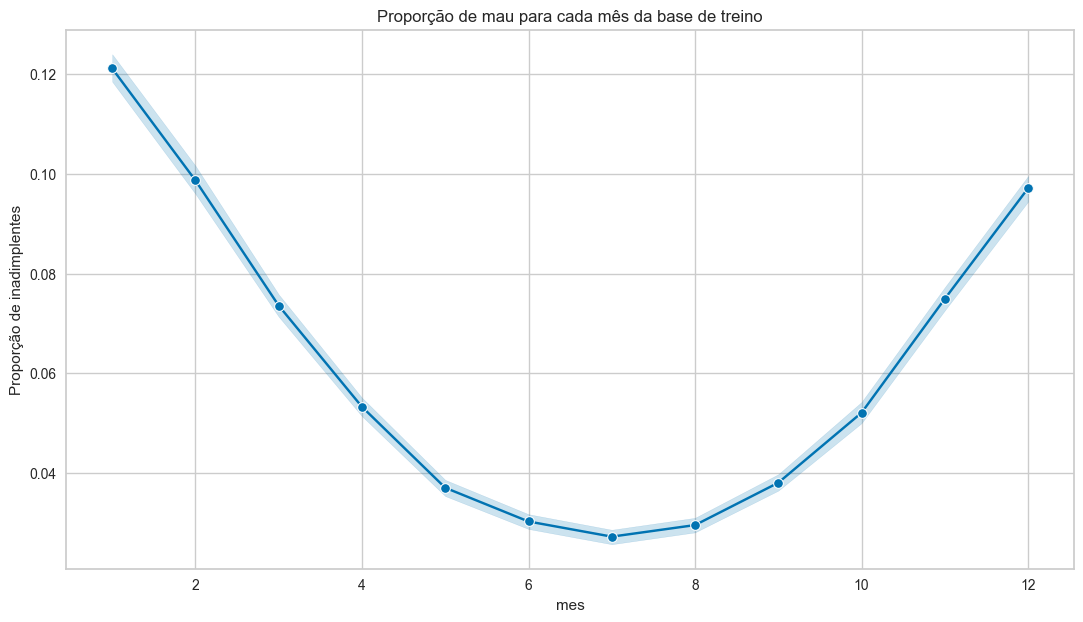

In [20]:
fig, ax = plt.subplots(figsize=(13, 7))
sns.lineplot(data=df_train, x='mes', y='mau', palette='viridis', ax=ax, marker='o')
ax.set_title('Proporção de mau para cada mês da base de treino')
ax.set_ylabel("Proporção de inadimplentes")

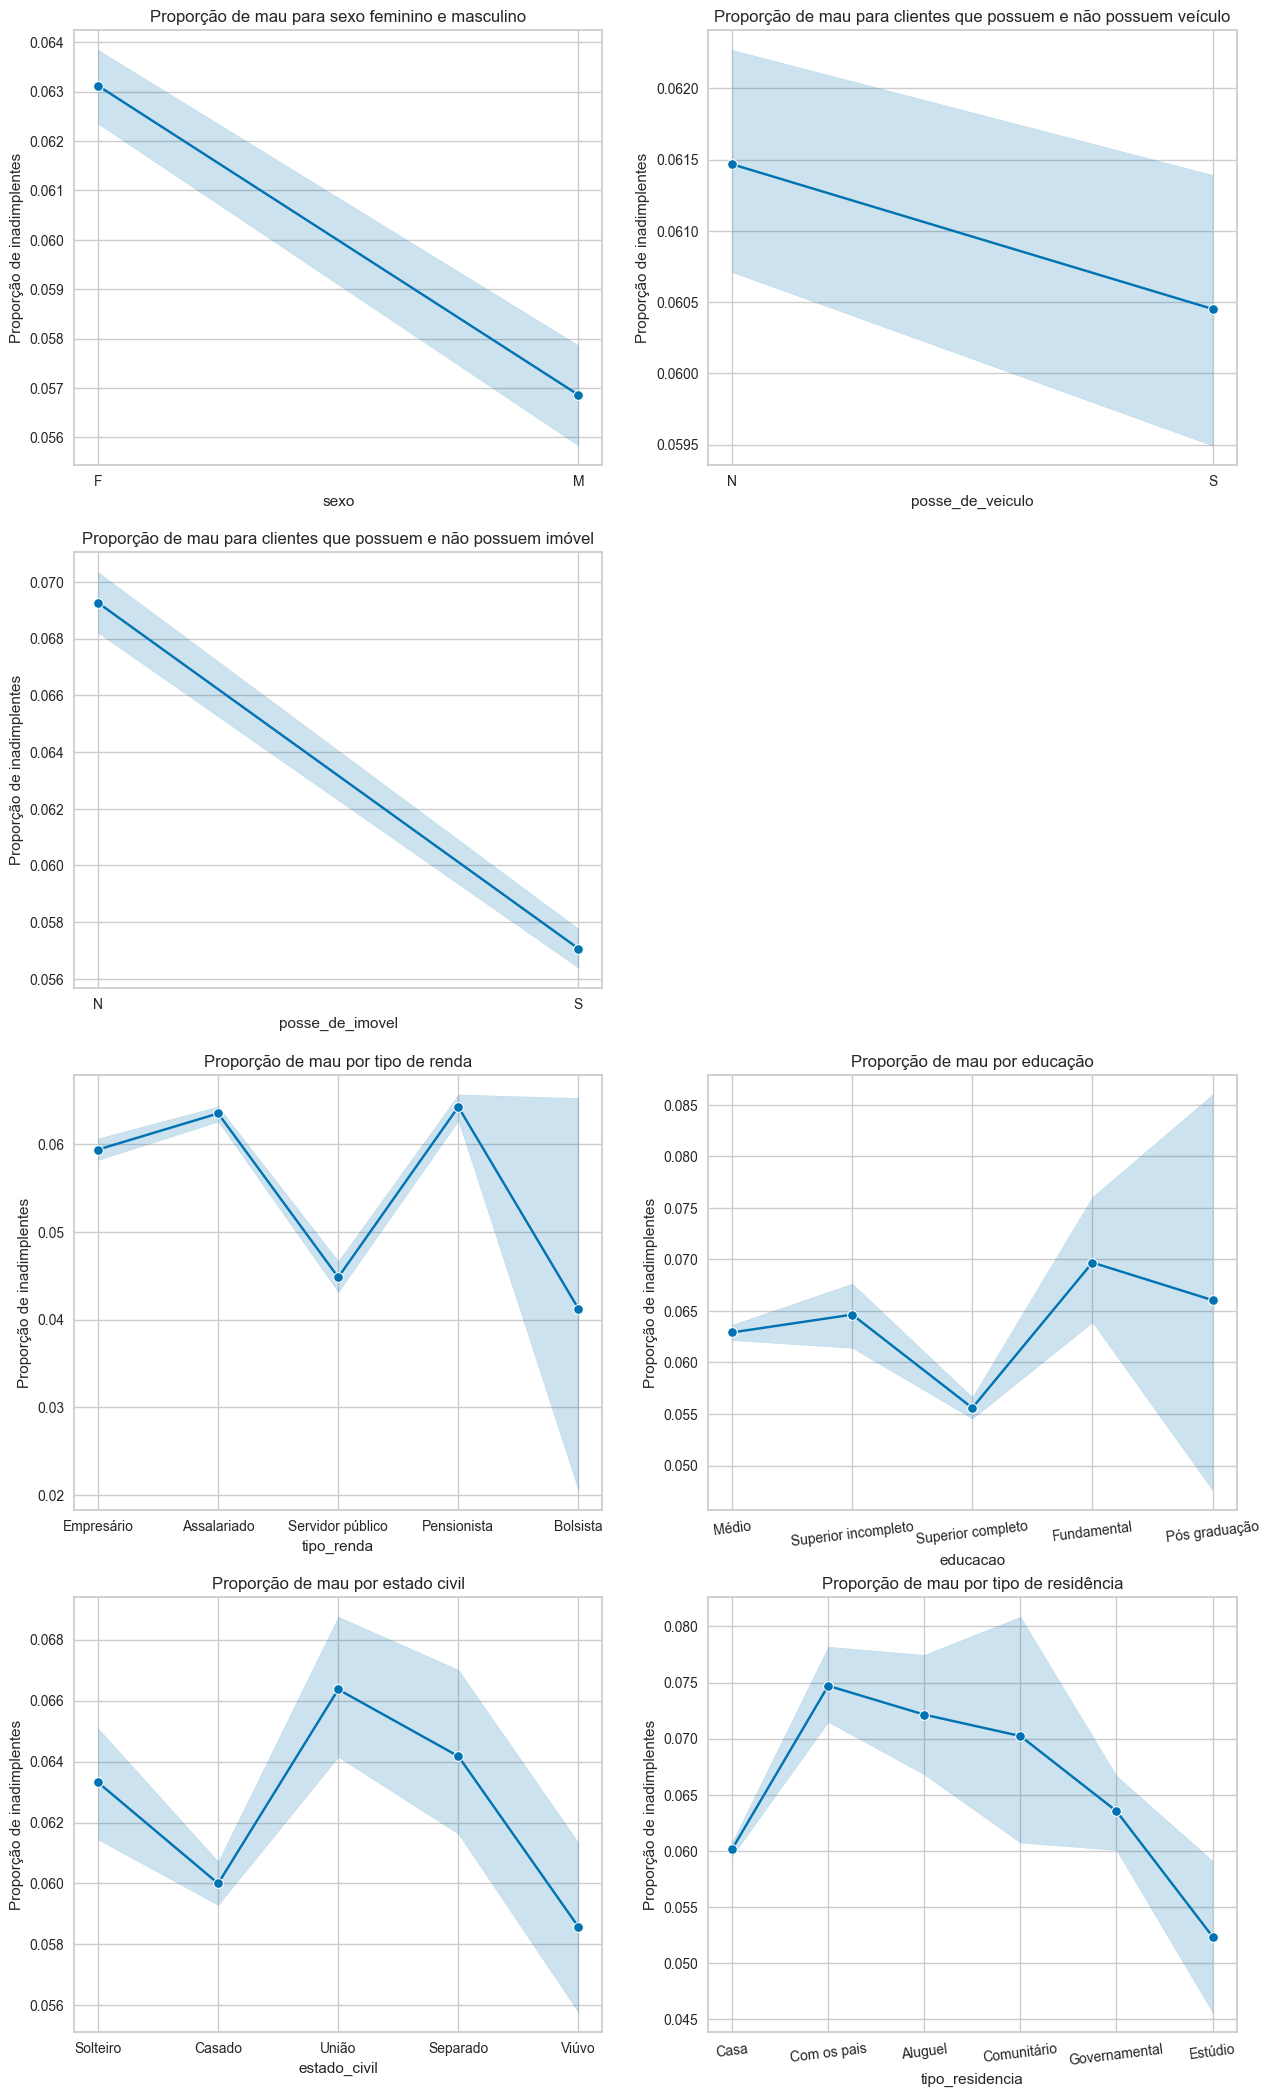

In [21]:
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(15, 26))

sns.lineplot(data=df_train, x='sexo', y='mau', palette='viridis', ax=ax[0, 0], marker='o')
ax[0, 0].set_title('Proporção de mau para sexo feminino e masculino')
ax[0, 0].set_ylabel("Proporção de inadimplentes")

sns.lineplot(data=df_train, x='posse_de_veiculo', y='mau', palette='viridis', ax=ax[0, 1], marker='o')
ax[0, 1].set_title('Proporção de mau para clientes que possuem e não possuem veículo')
ax[0, 1].set_ylabel("Proporção de inadimplentes")

sns.lineplot(data=df_train, x='posse_de_imovel', y='mau', palette='viridis', ax=ax[1, 0], marker='o')
ax[1, 0].set_title('Proporção de mau para clientes que possuem e não possuem imóvel')
ax[1, 0].set_ylabel("Proporção de inadimplentes")

ax[1, 1].axis('off')

sns.lineplot(data=df_train, x='tipo_renda', y='mau', palette='viridis', ax=ax[2, 0], marker='o')
ax[2, 0].set_title('Proporção de mau por tipo de renda')
ax[2, 0].set_ylabel("Proporção de inadimplentes")

sns.lineplot(data=df_train, x='educacao', y='mau', palette='viridis', ax=ax[2, 1], marker='o')
ax[2, 1].set_title('Proporção de mau por educação')
ax[2, 1].set_ylabel("Proporção de inadimplentes")
for tick in ax[2, 1].get_xticklabels():
    tick.set_rotation(7)

sns.lineplot(data=df_train, x='estado_civil', y='mau', palette='viridis', ax=ax[3, 0], marker='o')
ax[3, 0].set_title('Proporção de mau por estado civil')
ax[3, 0].set_ylabel("Proporção de inadimplentes")

sns.lineplot(data=df_train, x='tipo_residencia', y='mau', palette='viridis', ax=ax[3, 1], marker='o')
ax[3, 1].set_title('Proporção de mau por tipo de residência')
ax[3, 1].set_ylabel("Proporção de inadimplentes")
for tick in ax[3, 1].get_xticklabels():
    tick.set_rotation(7)

Text(0, 0.5, 'Proporção de inadimplentes')

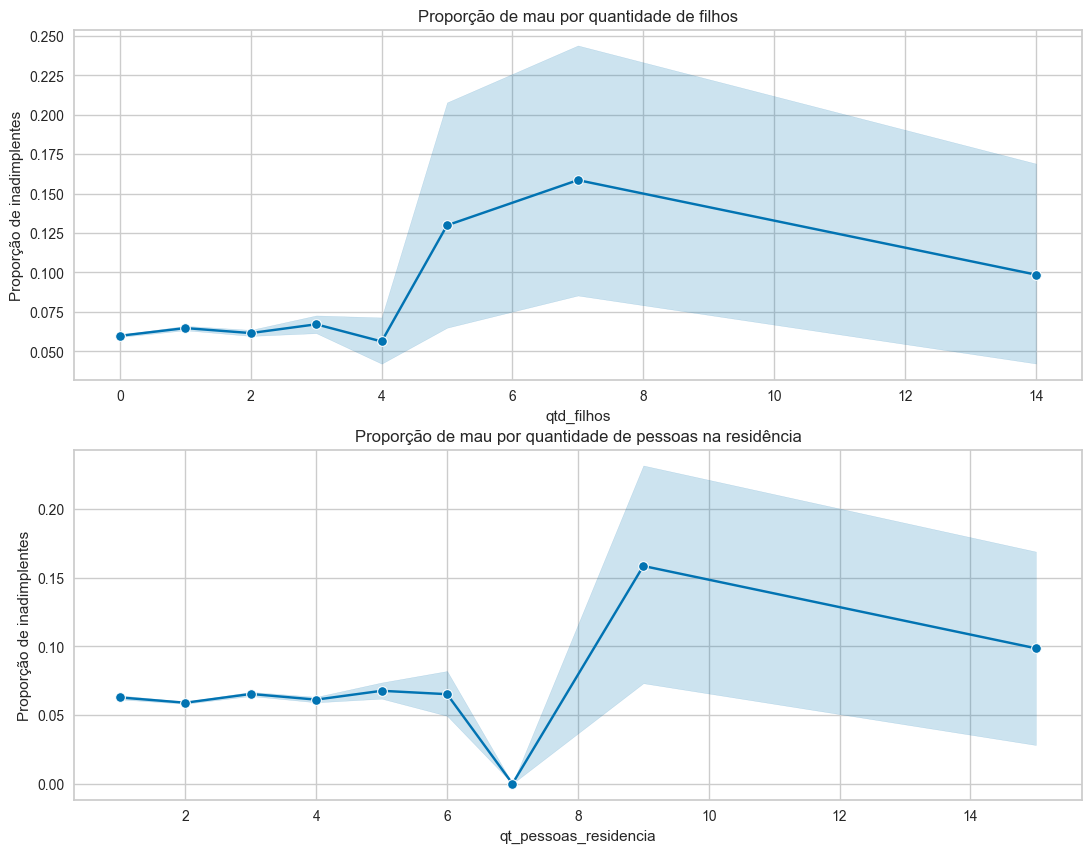

In [22]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(13, 10))

sns.lineplot(data=df_train, x='qtd_filhos', y='mau', palette='viridis', ax=ax[0], marker='o')
ax[0].set_title('Proporção de mau por quantidade de filhos')
ax[0].set_ylabel("Proporção de inadimplentes")

sns.lineplot(data=df_train, x='qt_pessoas_residencia', y='mau', palette='viridis', ax=ax[1], marker='o')
ax[1].set_title('Proporção de mau por quantidade de pessoas na residência')
ax[1].set_ylabel("Proporção de inadimplentes")

Text(0.5, 1.0, 'Proporção de mau para intervalos de renda')

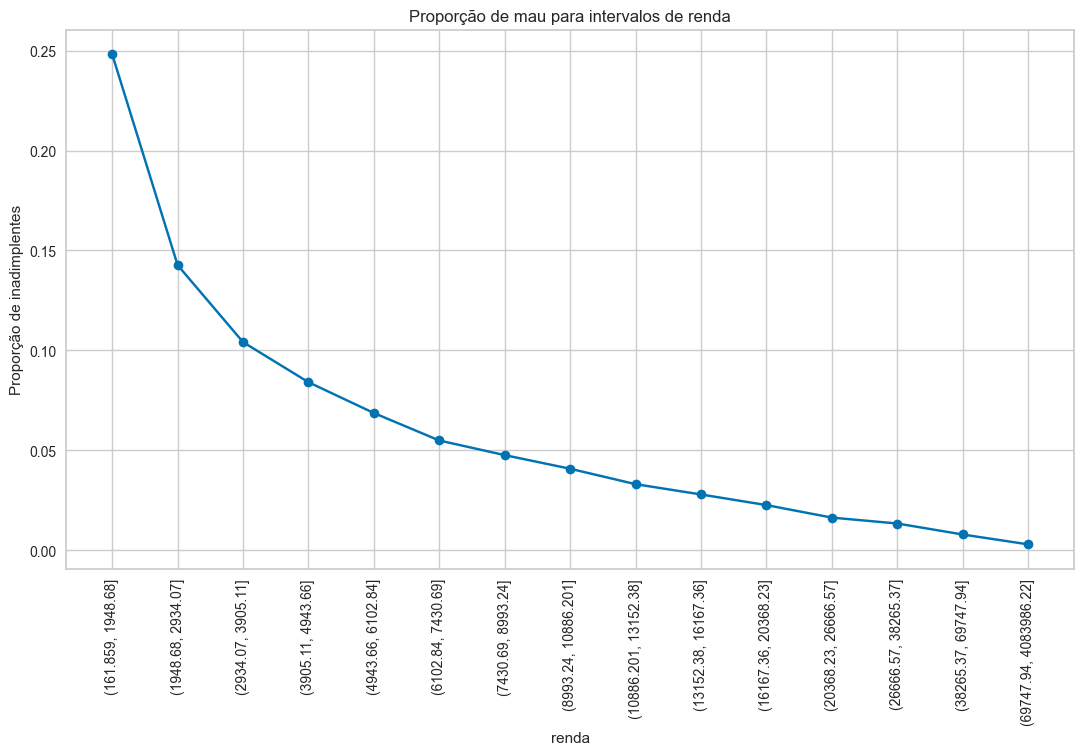

In [23]:
fig, ax = plt.subplots(figsize=(13, 7))

cat_1, bins = pd.qcut(df_train['renda'], 15, retbins=True)
df_1 = df_train.groupby(cat_1)
biv = df_1['mau'].mean()

ax = biv.plot.line(marker='o')
ax.set_ylabel("Proporção de inadimplentes")
ticks = plt.xticks(range(len(biv.index.values)), biv.index.values, rotation=90)
ax.set_title('Proporção de mau para intervalos de renda')

## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

In [24]:
df_train['mau'] = df_train.mau.astype('int64')
df_train.drop(columns=['data_ref', 'mes'], inplace=True)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600000 entries, 0 to 599999
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   sexo                   600000 non-null  object 
 1   posse_de_veiculo       600000 non-null  object 
 2   posse_de_imovel        600000 non-null  object 
 3   qtd_filhos             600000 non-null  int64  
 4   tipo_renda             600000 non-null  object 
 5   educacao               600000 non-null  object 
 6   estado_civil           600000 non-null  object 
 7   tipo_residencia        600000 non-null  object 
 8   idade                  600000 non-null  int64  
 9   tempo_emprego          499125 non-null  float64
 10  qt_pessoas_residencia  600000 non-null  float64
 11  renda                  600000 non-null  float64
 12  mau                    600000 non-null  int64  
dtypes: float64(3), int64(3), object(7)
memory usage: 59.5+ MB


#### Missings de Tempo de Emprego - Substituindo pela média

In [25]:
df_train['tempo_emprego'].fillna(value=df_train['tempo_emprego'].mean(), inplace=True)

#### Metadados

In [26]:
metadados = pd.DataFrame(df_train.dtypes, columns=['dtype'])
metadados['nmissing'] = df_train.isna().sum()
metadados['valores_unicos'] = df_train.nunique()
metadados['papel'] = 'covariavel'
metadados.loc['mau', 'papel'] = 'resposta'
metadados

,dtype,nmissing,valores_unicos,papel
sexo,object,0,2,covariavel
posse_de_veiculo,object,0,2,covariavel
posse_de_imovel,object,0,2,covariavel
qtd_filhos,int64,0,8,covariavel
tipo_renda,object,0,5,covariavel
educacao,object,0,5,covariavel
estado_civil,object,0,5,covariavel
tipo_residencia,object,0,6,covariavel
idade,int64,0,47,covariavel
tempo_emprego,float64,0,3005,covariavel


In [27]:
for var in metadados[metadados.papel == 'covariavel'].index:
    if (metadados.loc[var, 'valores_unicos'] > 10):
        metadados.loc[var, 'IV'] = IV(pd.qcut(df_train[var], 5, duplicates='drop'), df_train.mau)
    else:
        metadados.loc[var, 'IV'] = IV(df_train[var], df_train.mau)

metadados

,dtype,nmissing,valores_unicos,papel,IV
sexo,object,0,2,covariavel,0.002665
posse_de_veiculo,object,0,2,covariavel,0.000075
posse_de_imovel,object,0,2,covariavel,0.009690
qtd_filhos,int64,0,8,covariavel,0.001689
tipo_renda,object,0,5,covariavel,0.009718
educacao,object,0,5,covariavel,0.003690
estado_civil,object,0,5,covariavel,0.001305
tipo_residencia,object,0,6,covariavel,0.003330
idade,int64,0,47,covariavel,0.018434
tempo_emprego,float64,0,3005,covariavel,0.283956


,qt_bom,qt_mau,mau,sexo,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
sexo,,,,,,,,,,,,,,
F,378318,25487,0.063117,F,403805,0.000383,0.063867,0.062367,-2.697567,-2.684953,-2.710321,0.035125,0.047739,0.02237
M,185039,11156,0.056862,M,196195,0.000523,0.057887,0.055837,-2.808589,-2.789641,-2.827861,-0.075898,-0.056950,-0.09517


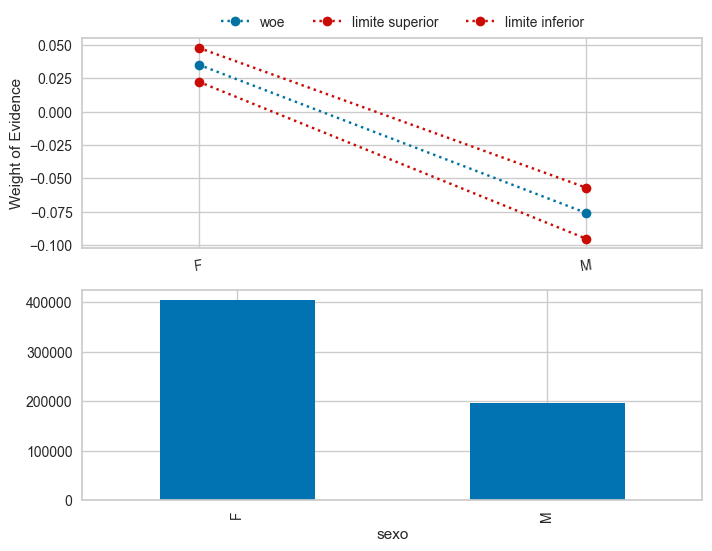

In [28]:
biv_discreta('sexo', df_train)

,qt_bom,qt_mau,mau,posse_de_veiculo,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
posse_de_veiculo,,,,,,,,,,,,,,
N,343778,22515,0.061467,N,366293,0.000397,0.062245,0.060689,-2.725814,-2.712410,-2.739378,0.006877,0.020281,-0.006687
S,219579,14128,0.060452,S,233707,0.000493,0.061418,0.059486,-2.743553,-2.726667,-2.760694,-0.010862,0.006024,-0.028003


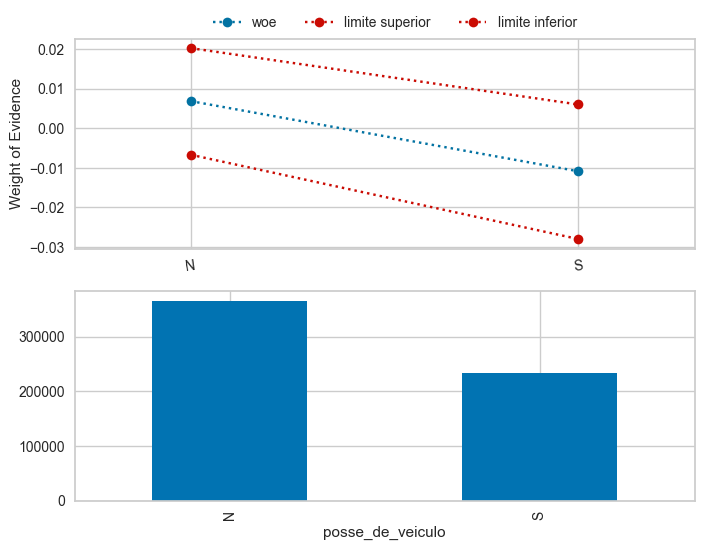

In [29]:
biv_discreta('posse_de_veiculo', df_train)

,qt_bom,qt_mau,mau,posse_de_imovel,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
posse_de_imovel,,,,,,,,,,,,,,
N,183305,13641,0.069263,N,196946,0.000572,0.070384,0.068141,-2.598071,-2.580806,-2.615598,0.134620,0.151885,0.117093
S,380052,23002,0.057069,S,403054,0.000365,0.057785,0.056353,-2.804727,-2.791496,-2.818114,-0.072036,-0.058805,-0.085423


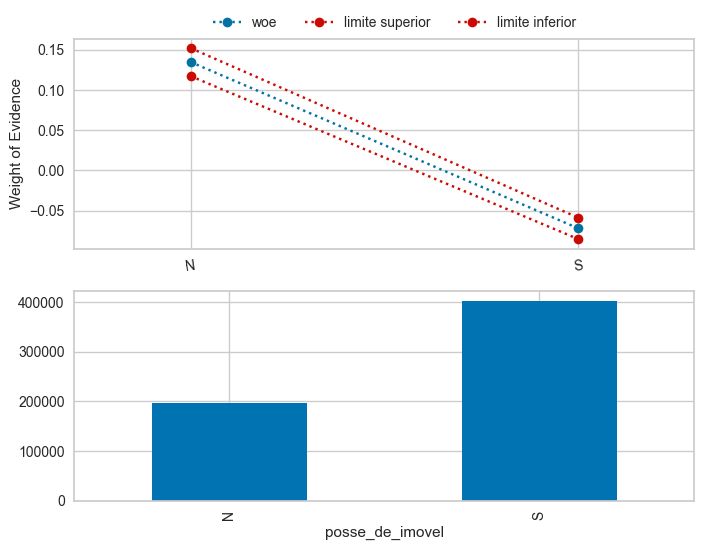

In [30]:
biv_discreta('posse_de_imovel', df_train)

,qt_bom,qt_mau,mau,qtd_filhos,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
qtd_filhos,,,,,,,,,,,,,,
0,389129,24753,0.059807,0,413882,0.000369,0.060529,0.059084,-2.754964,-2.742189,-2.767885,-0.022273,-0.009497,-0.035194
1,114547,7924,0.064701,1,122471,0.000703,0.066079,0.063323,-2.671089,-2.648545,-2.694085,0.061602,0.084147,0.038606
2,52182,3421,0.061525,2,55603,0.001019,0.063523,0.059528,-2.724805,-2.690727,-2.759933,0.007886,0.041964,-0.027241
3,6493,467,0.067098,3,6960,0.002999,0.072977,0.061219,-2.632151,-2.541841,-2.730127,0.100540,0.190850,0.002564
4,806,48,0.056206,4,854,0.007881,0.071675,0.040737,-2.820883,-2.561236,-3.159030,-0.088192,0.171455,-0.426339
5,67,10,0.129870,5,77,0.038309,0.206169,0.053571,-1.902108,-1.348173,-2.871687,0.830584,1.384518,-0.138996
7,69,13,0.158537,7,82,0.040334,0.238789,0.078284,-1.669157,-1.159328,-2.465897,1.063534,1.573363,0.266795
14,64,7,0.098592,14,71,0.035379,0.169154,0.028029,-2.212973,-1.591637,-3.546072,0.519718,1.141054,-0.813381


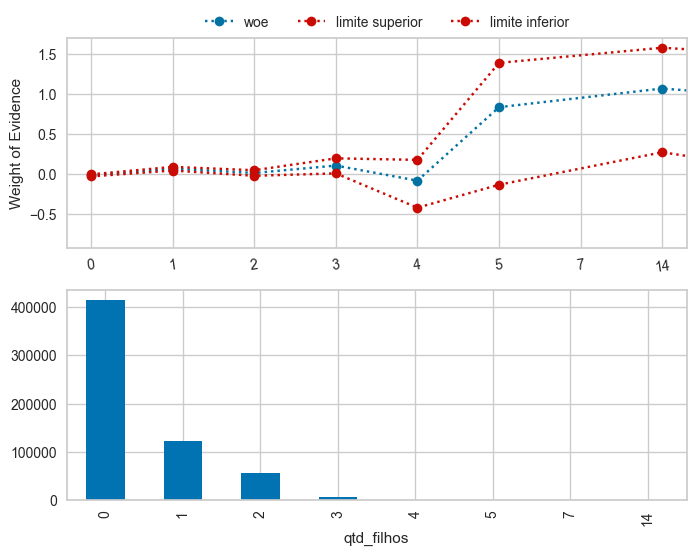

In [31]:
biv_discreta('qtd_filhos', df_train)

,qt_bom,qt_mau,mau,tipo_renda,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
tipo_renda,,,,,,,,,,,,,,
Assalariado,288865,19595,0.063525,Assalariado,308460,0.000439,0.064386,0.062665,-2.690685,-2.676307,-2.705246,0.042006,0.056384,0.027445
Bolsista,279,12,0.041237,Bolsista,291,0.011656,0.064178,0.018296,-3.146305,-2.679758,-3.982616,-0.413614,0.052933,-1.249925
Empresário,129935,8206,0.059403,Empresário,138141,0.000636,0.060650,0.058157,-2.762169,-2.740076,-2.784700,-0.029478,-0.007385,-0.052009
Pensionista,94627,6500,0.064276,Pensionista,101127,0.000771,0.065787,0.062764,-2.678141,-2.653280,-2.703552,0.054550,0.079411,0.029139
Servidor público,49651,2330,0.044824,Servidor público,51981,0.000908,0.046603,0.043045,-3.059150,-3.018369,-3.101504,-0.326459,-0.285678,-0.368813


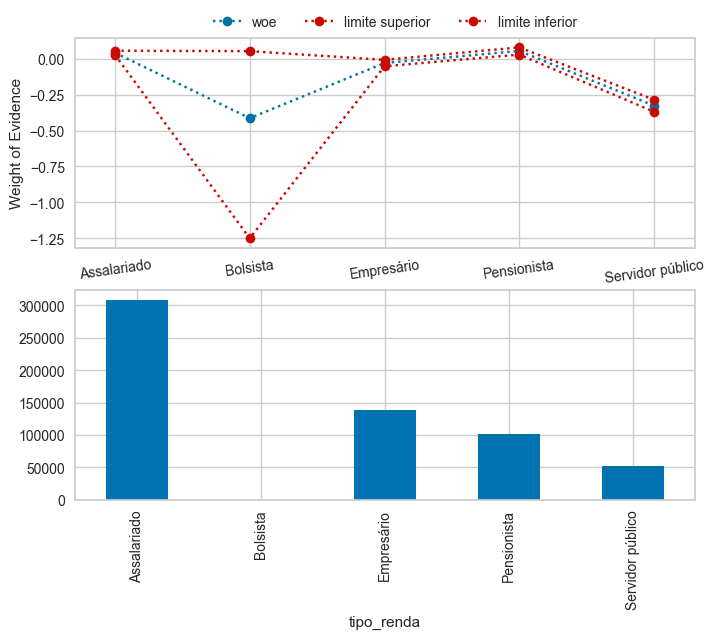

In [32]:
biv_discreta('tipo_renda', df_train)

0.009634301334170859

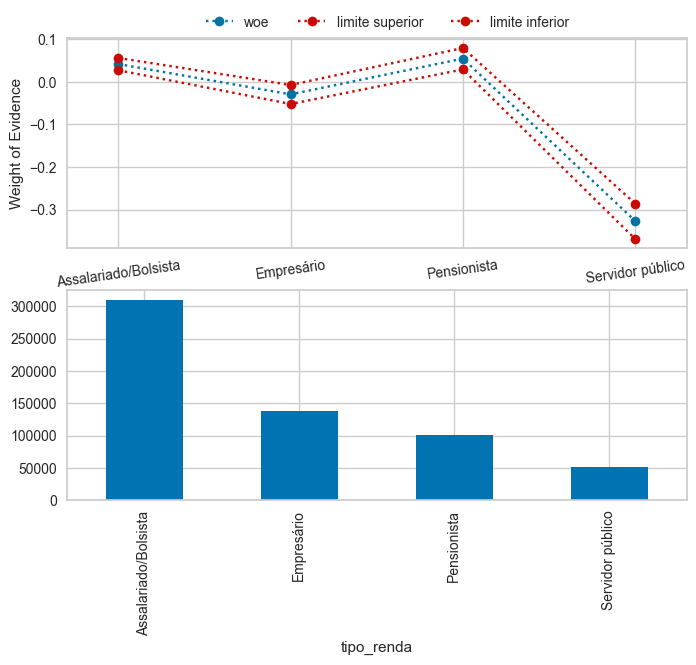

In [33]:
# Agrupando as classes da variável tipo de renda

df_train.tipo_renda.replace(
    {'Assalariado': 'Assalariado/Bolsista',
     'Bolsista': 'Assalariado/Bolsista'}, inplace=True)

biv_discreta('tipo_renda', df_train)
IV(df_train.tipo_renda, df_train.mau)

,qt_bom,qt_mau,mau,educacao,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
educacao,,,,,,,,,,,,,,
Fundamental,6420,481,0.069700,Fundamental,6901,0.003065,0.075709,0.063691,-2.591306,-2.502130,-2.687900,0.141385,0.230561,0.044791
Médio,379939,25510,0.062918,Médio,405449,0.000381,0.063665,0.062170,-2.700940,-2.688333,-2.713688,0.031751,0.044358,0.019003
Pós graduação,608,43,0.066052,Pós graduação,651,0.009735,0.085167,0.046937,-2.648975,-2.374126,-3.010867,0.083716,0.358565,-0.278176
Superior completo,154354,9086,0.055592,Superior completo,163440,0.000567,0.056703,0.054481,-2.832514,-2.811552,-2.853874,-0.099823,-0.078861,-0.121183
Superior incompleto,22036,1523,0.064646,Superior incompleto,23559,0.001602,0.067786,0.061506,-2.671995,-2.621201,-2.725141,0.060696,0.111490,0.007550


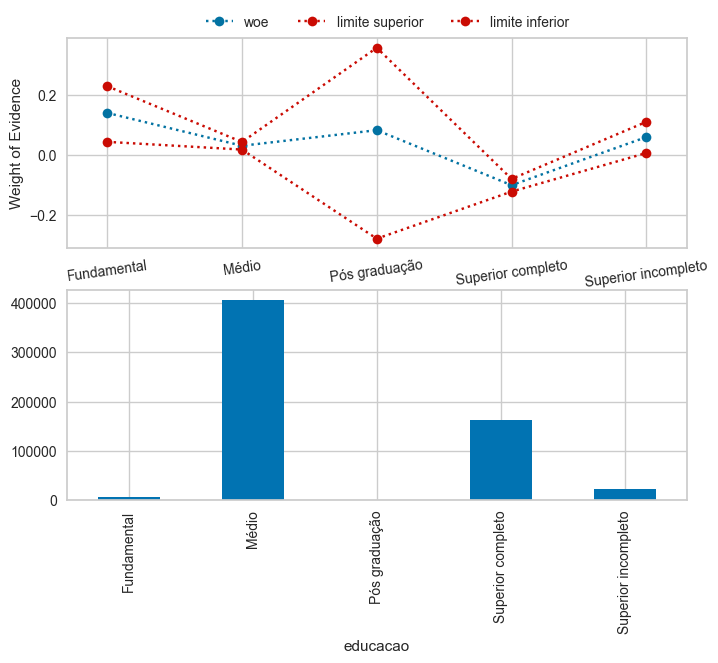

In [34]:
biv_discreta('educacao', df_train)

0.0034801108923340892

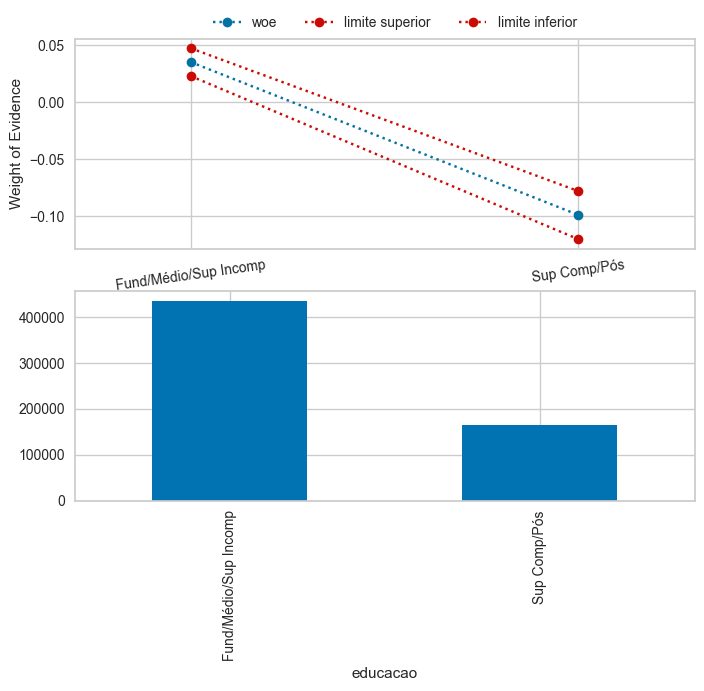

In [35]:
# Agrupando as classes da variável educacao

df_train.educacao.replace(
    {'Fundamental': 'Fund/Médio/Sup Incomp',
     'Médio': 'Fund/Médio/Sup Incomp',
     'Superior incompleto': 'Fund/Médio/Sup Incomp',
     'Superior completo': 'Sup Comp/Pós',
     'Pós graduação': 'Sup Comp/Pós'}, inplace=True)

biv_discreta('educacao', df_train)
IV(df_train.educacao, df_train.mau)

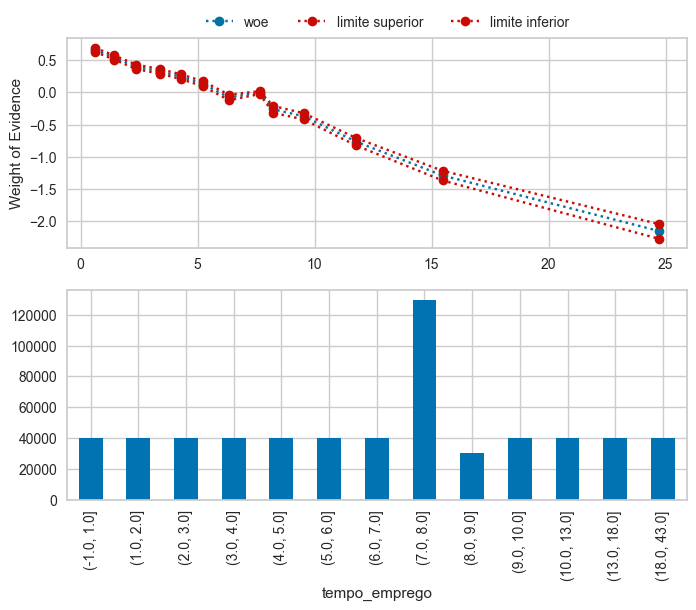

In [36]:
biv_continua('tempo_emprego', 15, df_train)

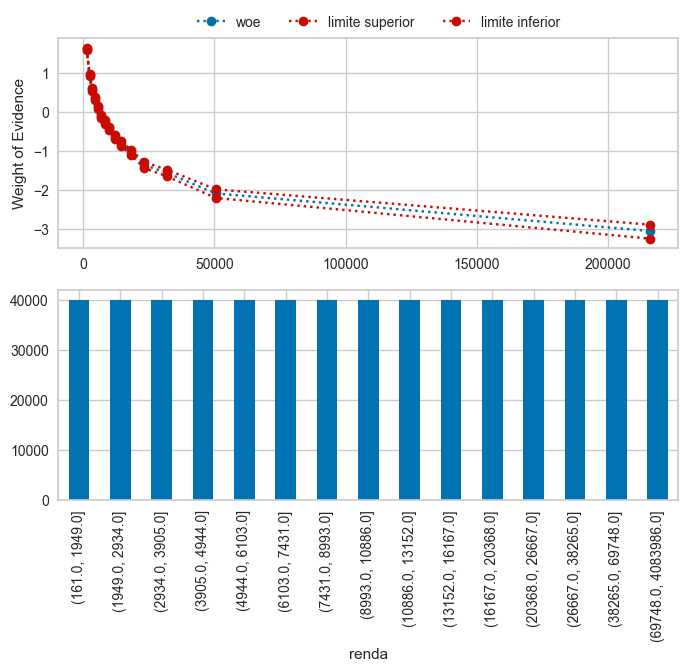

In [37]:
biv_continua('renda', 15, df_train)

In [38]:
' + '.join(list(metadados.sort_values(by='IV', ascending=False).index))

'qt_pessoas_residencia + renda + tempo_emprego + idade + tipo_renda + posse_de_imovel + educacao + tipo_residencia + sexo + qtd_filhos + estado_civil + posse_de_veiculo + mau'

In [39]:
formula = '''
    mau ~ sexo + posse_de_veiculo + posse_de_imovel + qtd_filhos + tipo_renda + 
    educacao + estado_civil + tipo_residencia + idade + tempo_emprego +
    renda
'''

rl = smf.glm(formula, data=df_train, family=sm.families.Binomial()).fit()

rl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    mau   No. Observations:               600000
Model:                            GLM   Df Residuals:                   599979
Model Family:                Binomial   Df Model:                           20
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.2488e+05
Date:                Wed, 27 Mar 2024   Deviance:                   2.4965e+05
Time:                        19:53:25   Pearson chi2:                 1.57e+16
No. Iterations:                    11   Pseudo R-squ. (CS):            0.04260
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                           -1.4189      0.053    -26.825      0.000      -1.523      -1.315
sexo[T.M]                           -0.1255      0.013     -9.567      0.000      -0.151      -0.100
posse_de_veiculo[T.S]                0.0313      0.012      2.529      0.011       0.007       0.056
posse_de_imovel[T.S]                -0.0847      0.012     -7.178      0.000      -0.108      -0.062
tipo_renda[T.Empresário]            -0.0545      0.014     -3.900      0.000      -0.082      -0.027
tipo_renda[T.Pensionista]           -0.0411      0.020     -2.032      0.042      -0.081      -0.001
tipo_renda[T.Servidor público]      -0.0330      0.023     -1.421      0.155      -0.079       0.013
educacao[T.Sup Comp/Pós]            -0.0566      0.013     -4.326      0.000      -0.082      -0.031
estado_civil[T.Separado]             0.0374      0.024      1.574      0.116      -0.009       0.084
estado_civil[T.Solteiro]             0.0054      0.017      0.311      0.756      -0.029       0.039
estado_civil[T.União]                0.0472      0.020      2.322      0.020       0.007       0.087
estado_civil[T.Viúvo]               -0.0346      0.029     -1.192      0.233      -0.092       0.022
tipo_residencia[T.Casa]             -0.0879      0.044     -1.995      0.046      -0.174      -0.002
tipo_residencia[T.Com os pais]      -0.0731      0.050     -1.475      0.140      -0.170       0.024
tipo_residencia[T.Comunitário]      -0.1403      0.089     -1.572      0.116      -0.315       0.035
tipo_residencia[T.Estúdio]          -0.0327      0.082     -0.397      0.691      -0.194       0.129
tipo_residencia[T.Governamental]    -0.0834      0.053     -1.565      0.118      -0.188       0.021
qtd_filhos                           0.0036      0.008      0.448      0.654      -0.012       0.019
idade                                0.0003      0.001      0.394      0.693      -0.001       0.002
tempo_emprego                       -0.0236      0.002    -13.100      0.000      -0.027      -0.020
renda                               -0.0001   1.09e-06    -93.691      0.000      -0.000   -9.96e-05
====================================================================================================
"""

In [40]:
formula = '''
    mau ~ sexo + posse_de_imovel + educacao +
    tempo_emprego + renda
'''

rl = smf.glm(formula, data=df_train, family=sm.families.Binomial()).fit()

rl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    mau   No. Observations:               600000
Model:                            GLM   Df Residuals:                   599994
Model Family:                Binomial   Df Model:                            5
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.2490e+05
Date:                Wed, 27 Mar 2024   Deviance:                   2.4969e+05
Time:                        19:53:30   Pearson chi2:                 1.59e+16
No. Iterations:                    11   Pseudo R-squ. (CS):            0.04253
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -1.4931      0.014   -107.439      0.000      -1.520      -1.466
sexo[T.M]                   -0.1072      0.012     -8.926      0.000      -0.131      -0.084
posse_de_imovel[T.S]        -0.0897      0.011     -7.845      0.000      -0.112      -0.067
educacao[T.Sup Comp/Pós]    -0.0569      0.013     -4.477      0.000      -0.082      -0.032
tempo_emprego               -0.0245      0.002    -14.616      0.000      -0.028      -0.021
renda                       -0.0001   1.08e-06    -94.209      0.000      -0.000   -9.96e-05
============================================================================================
"""

## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

In [41]:
df_train['score'] = rl.predict(df_train)

# Acurácia
acc = metrics.accuracy_score(df_train.mau, df_train.score > .068)

# AUC
fpr, tpr, thresholds = metrics.roc_curve(df_train.mau, df_train.score)
auc = metrics.auc(fpr, tpr)

# Gini
gini = 2*auc - 1
ks = ks_2samp(df_train.loc[df_train.mau == 1, 'score'],
              df_train.loc[df_train.mau != 1, 'score']).statistic

print('Acurácia: {0:.1%} \nAUC: {1:.1%} \nGINI: {2:.1%}\nKS: {3:.1%}'.format(acc, auc, gini, ks))

Acurácia: 59.4% 
AUC: 76.6% 
GINI: 53.2%
KS: 39.4%


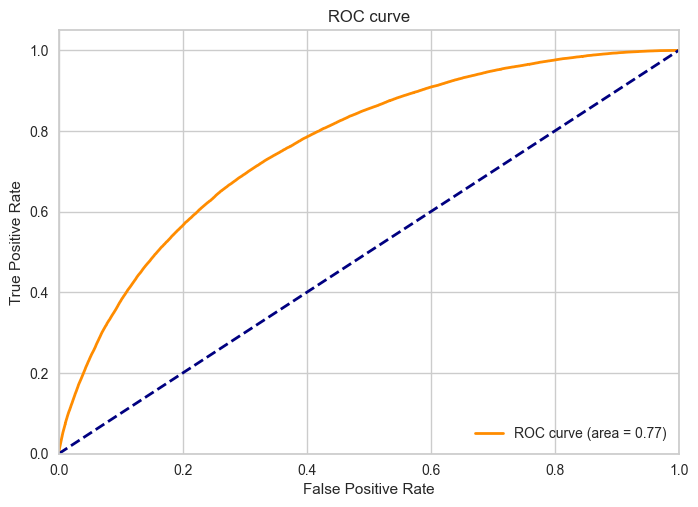

In [42]:
fpr, tpr, thresholds = metrics.roc_curve(df_train['mau'], df_train['score'])

plt.figure()
lw = 2

fpr, tpr, thresholds = metrics.roc_curve(df_train['mau'], df_train['score'])
auc_ = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % auc_)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

Text(0, 0.5, 'Função Distribuição Acumulada')

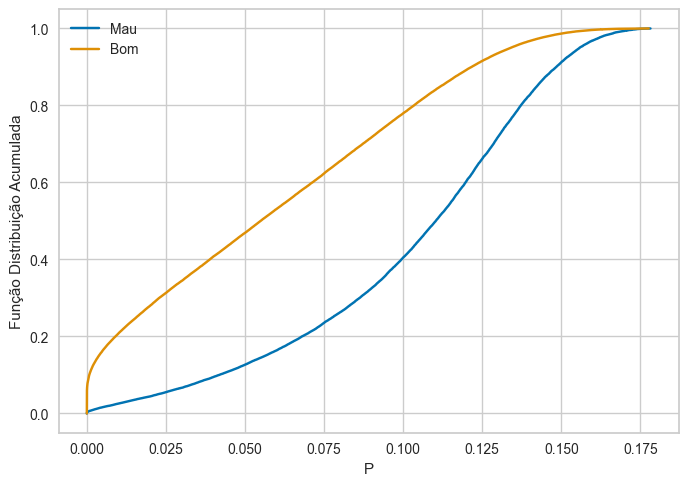

In [43]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

score_pop1 = df_train.loc[df_train['mau'] == 1, 'score']
ax.plot(np.sort(score_pop1), np.linspace(0, 1, len(score_pop1), endpoint=False), label='Mau')

score_pop2 = df_train.loc[df_train['mau'] != 1, 'score']
ax.plot(np.sort(score_pop2), np.linspace(0, 1, len(score_pop2), endpoint=False), label='Bom')
ax.legend()

ax.set_xlabel('P')
ax.set_ylabel('Função Distribuição Acumulada')

#### Base Out of time

In [44]:
df_test['tempo_emprego'].fillna(value=df_test['tempo_emprego'].mean(), inplace=True)

In [45]:
df_test.educacao.replace(
    {'Fundamental': 'Fund/Médio/Sup Incomp',
     'Médio': 'Fund/Médio/Sup Incomp',
     'Superior incompleto': 'Fund/Médio/Sup Incomp',
     'Superior completo': 'Sup Comp/Pós',
     'Pós graduação': 'Sup Comp/Pós'}, inplace=True)

In [46]:
df_test['score'] = rl.predict(df_test)

# Acurácia
acc = metrics.accuracy_score(df_test.mau, df_test.score > .068)

# AUC
fpr, tpr, thresholds = metrics.roc_curve(df_test.mau, df_test.score)
auc = metrics.auc(fpr, tpr)

# Gini
gini = 2*auc - 1
ks = ks_2samp(df_test.loc[df_test.mau == 1, 'score'],
              df_test.loc[df_test.mau != 1, 'score']).statistic

print('Acurácia: {0:.1%} \nAUC: {1:.1%} \nGINI: {2:.1%}\nKS: {3:.1%}'.format(acc, auc, gini, ks))

Acurácia: 32.6% 
AUC: 72.5% 
GINI: 44.9%
KS: 32.9%


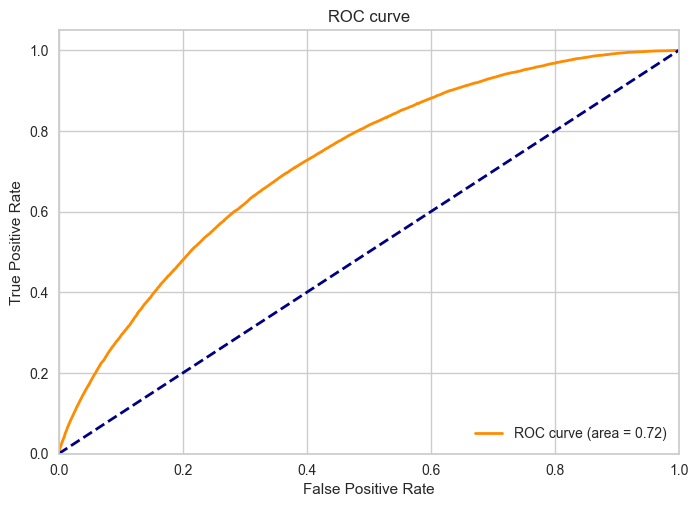

In [47]:
fpr, tpr, thresholds = metrics.roc_curve(df_test['mau'], df_test['score'])

plt.figure()
lw = 2

fpr, tpr, thresholds = metrics.roc_curve(df_test['mau'], df_test['score'])
auc_ = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc_)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

Text(0, 0.5, 'Função Distribuição Acumulada')

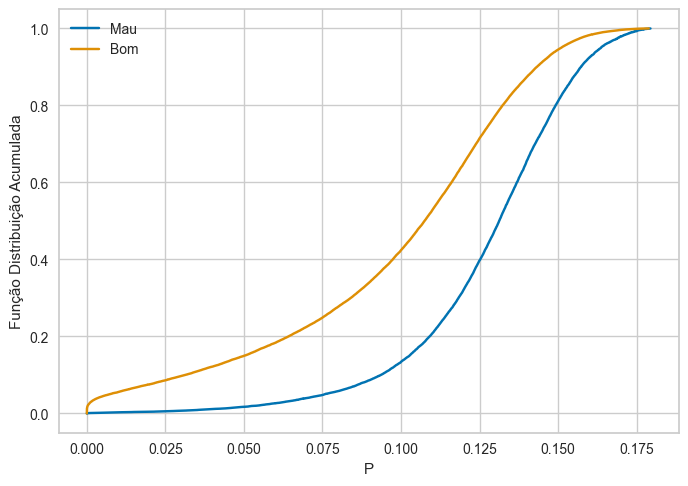

In [48]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

score_pop1 = df_test.loc[df_test['mau'] == 1, 'score']
ax.plot(np.sort(score_pop1), np.linspace(0, 1, len(score_pop1), endpoint=False), label='Mau')

score_pop2 = df_test.loc[df_test['mau'] != 1, 'score']
ax.plot(np.sort(score_pop2), np.linspace(0, 1, len(score_pop2), endpoint=False), label='Bom')
ax.legend()

ax.set_xlabel('P')
ax.set_ylabel('Função Distribuição Acumulada')

## Criar um pipeline utilizando o sklearn pipeline 

## Pré processamento

### Substituição de nulos (nans)

Existe nulos na base? é dado numérico ou categórico? qual o valor de substituição? média? valor mais frequente? etc

In [49]:
df.isnull().sum()

sexo                          0
posse_de_veiculo              0
posse_de_imovel               0
qtd_filhos                    0
tipo_renda                    0
educacao                      0
estado_civil                  0
tipo_residencia               0
idade                         0
tempo_emprego            100875
qt_pessoas_residencia         0
renda                         0
mau                           0
dtype: int64

In [50]:
df['tempo_emprego'] = df['tempo_emprego'].fillna(df['tempo_emprego'].median())

### Remoção de outliers

Como identificar outlier? Substituir o outlier por algum valor? Remover a linha?

<Axes: xlabel='tempo_emprego', ylabel='renda'>

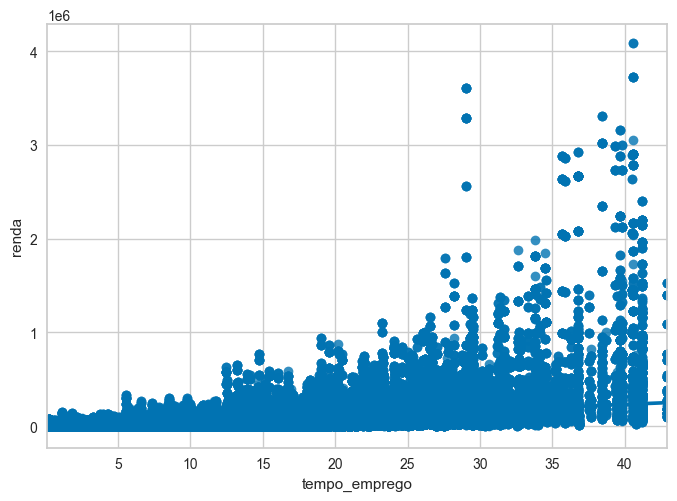

In [51]:
sns.regplot(y='renda', x='tempo_emprego', data=df)

### Seleção de variáveis

Qual tipo de técnica? Boruta? Feature importance? 

In [52]:
variaveis = ['renda', 'posse_de_imovel', 'idade', 'tempo_emprego', 'qt_pessoas_residencia']

In [53]:
dataset = df.sample(400)

In [55]:
exp_aula = setup(data=dataset,
                 target='mau',
                 experiment_name='credit_1',
                 normalize=True,
                 normalize_method='zscore',
                 transformation=True,
                 transformation_method='quantile',
                 fix_imbalance=True,
                 index=False)


,Description,Value
0,Session id,274
1,Target,mau
2,Target type,Binary
3,Original data shape,"(10914, 13)"
4,Transformed data shape,"(17451, 30)"
5,Transformed train set shape,"(14176, 30)"
6,Transformed test set shape,"(3275, 30)"
7,Numeric features,5
8,Categorical features,7
9,Preprocess,True


In [56]:
best_model = compare_models(fold=4, sort='AUC')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.8688,0.0000,0.1216,0.1132,0.1172,0.0464,0.0465,0.9825
knn,K Neighbors Classifier,0.9225,0.0000,0.0127,0.1360,0.0231,0.0102,0.0195,0.8625
nb,Naive Bayes,0.4286,0.0000,0.6494,0.0811,0.1425,0.0176,0.0289,0.8325
dt,Decision Tree Classifier,0.8417,0.0000,0.1997,0.1261,0.1542,0.0721,0.0745,0.8300
svm,SVM - Linear Kernel,0.8640,0.0000,0.0997,0.0930,0.0826,0.0184,0.0205,0.0800
ridge,Ridge Classifier,0.8704,0.0000,0.0998,0.1006,0.1002,0.0304,0.0304,0.0650
rf,Random Forest Classifier,0.8407,0.0000,0.2087,0.1285,0.1589,0.0765,0.0793,0.1475
qda,Quadratic Discriminant Analysis,0.9279,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0700
ada,Ada Boost Classifier,0.8526,0.0000,0.1561,0.1157,0.1326,0.0542,0.0550,0.2025
gbc,Gradient Boosting Classifier,0.8783,0.0000,0.0925,0.1051,0.0980,0.0334,0.0335,0.4625


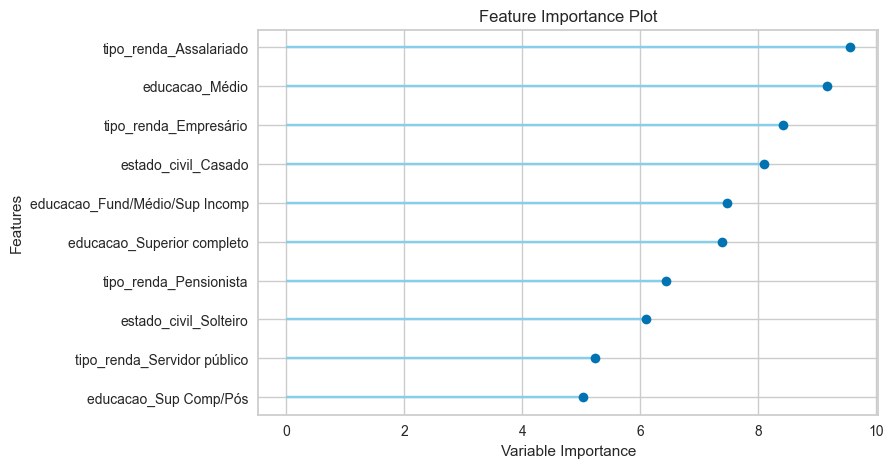

In [57]:
plot_model(best_model, plot='feature')

In [58]:
save_model(best_model,'Model Projeto Final 122022')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['qtd_filhos', 'idade',
                                              'tempo_emprego',
                                              'qt_pessoas_residencia', 'renda'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='mean'))),
                 ('categorical_imputer',
                  TransformerWra...
                  TransformerWrapper(exclude=None, include=None,
                     

### Criação de dummies

Aplicar o get_dummies() ou onehotencoder() para transformar colunas catégoricas do dataframe em colunas de 0 e 1. 
- sexo
- posse_de_veiculo
- posse_de_imovel
- tipo_renda
- educacao
- estado_civil
- tipo_residencia

In [59]:
df1 = pd.get_dummies(dataset, columns=[
    'tipo_residencia',
    'estado_civil',
    'educacao',
    'tipo_renda',
    'posse_de_imovel',
    'posse_de_veiculo',
    'sexo'
], drop_first=True)

df1.head()

,qtd_filhos,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,tipo_residencia_Casa,tipo_residencia_Com os pais,tipo_residencia_Comunitário,tipo_residencia_Estúdio,...,educacao_Médio,educacao_Sup Comp/Pós,educacao_Superior completo,educacao_Superior incompleto,tipo_renda_Empresário,tipo_renda_Pensionista,tipo_renda_Servidor público,posse_de_imovel_S,posse_de_veiculo_S,sexo_M
data_ref,,,,,,,,,,,,,,,,,,,,,
2015-09-01,1,47,3.101370,3.0,1687.56,False,True,False,False,False,...,True,False,False,False,False,False,False,False,False,False
2015-02-01,3,36,1.512329,5.0,1169.11,False,True,False,False,False,...,True,False,False,False,False,False,False,False,False,False
2015-12-01,1,27,0.254795,2.0,3464.28,True,True,False,False,False,...,False,False,True,False,False,False,False,True,False,False
2015-08-01,1,28,5.931507,3.0,15627.72,False,True,False,False,False,...,False,False,True,False,False,False,False,True,True,True
2015-07-01,0,53,7.610959,2.0,44625.54,False,False,False,False,False,...,True,False,False,False,True,False,False,True,False,False


# Pycaret na base de dados 

Utilize o pycaret para pre processar os dados e rodar o modelo **lightgbm**. Faça todos os passos a passos da aula e gere os gráficos finais. E o pipeline de toda a transformação.



In [60]:
dataset = df.sample(400)

In [61]:
data = dataset.sample(frac=0.95, random_state=786)
data_unseen = dataset.drop(data.index)
data.reset_index(inplace=True, drop=True)
data_unseen.reset_index(inplace=True, drop=True)
print('Conjunto de dados para modelagem (treino e teste): ' + str(data.shape))
print('Conjunto de dados não usados no treino/teste, apenas como validação: ' + str(data_unseen.shape))

Conjunto de dados para modelagem (treino e teste): (380, 13)
Conjunto de dados não usados no treino/teste, apenas como validação: (0, 13)


In [62]:
best_model = compare_models(fold=5, sort='Accuracy')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
qda,Quadratic Discriminant Analysis,0.9279,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0640
dummy,Dummy Classifier,0.9279,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0600
knn,K Neighbors Classifier,0.9232,0.0000,0.0108,0.1415,0.0199,0.0085,0.0178,0.0780
svm,SVM - Linear Kernel,0.8873,0.0000,0.0671,0.0936,0.0777,0.0201,0.0203,0.0720
gbc,Gradient Boosting Classifier,0.8641,0.0000,0.0999,0.0917,0.0954,0.0222,0.0223,0.4040
lr,Logistic Regression,0.8591,0.0000,0.1417,0.1130,0.1249,0.0497,0.0504,0.0680
lda,Linear Discriminant Analysis,0.8557,0.0000,0.1363,0.1067,0.1186,0.0423,0.0427,0.0600
ada,Ada Boost Classifier,0.8525,0.0000,0.1489,0.1117,0.1268,0.0486,0.0494,0.1700
ridge,Ridge Classifier,0.8521,0.0000,0.1452,0.1098,0.1245,0.0460,0.0465,0.0580
et,Extra Trees Classifier,0.8345,0.0000,0.2306,0.1317,0.1667,0.0830,0.0872,0.1220


In [63]:
print(best_model)

QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
                              store_covariance=False, tol=0.0001)


In [64]:
modelo_et = create_model('et')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8442,0.0000,0.2909,0.1667,0.2119,0.1325,0.1389
1,0.8390,0.0000,0.2727,0.1531,0.1961,0.1144,0.1203
2,0.8285,0.0000,0.2364,0.1275,0.1656,0.0795,0.0842
3,0.8128,0.0000,0.2545,0.1207,0.1637,0.0732,0.0797
4,0.8181,0.0000,0.2909,0.1379,0.1871,0.0991,0.1079
5,0.8233,0.0000,0.2545,0.1296,0.1718,0.0844,0.0905
6,0.8364,0.0000,0.2182,0.1277,0.1611,0.0773,0.0807
7,0.8037,0.0000,0.1818,0.0870,0.1176,0.0224,0.0244
8,0.8024,0.0000,0.3036,0.1318,0.1838,0.0908,0.1011


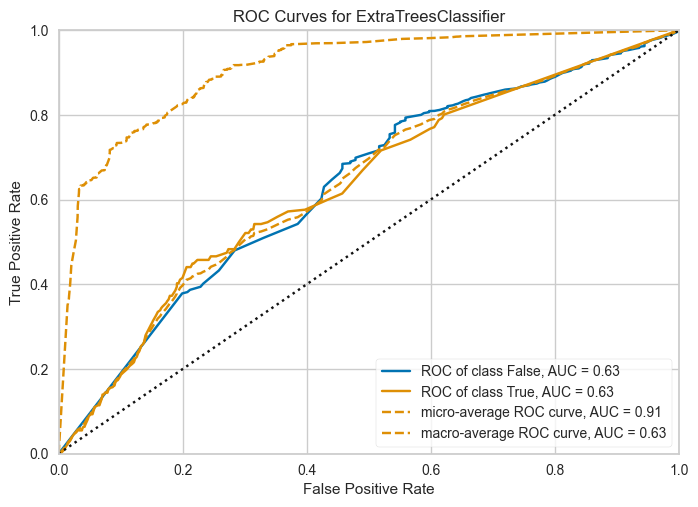

In [65]:
plot_model(modelo_et, plot='auc')

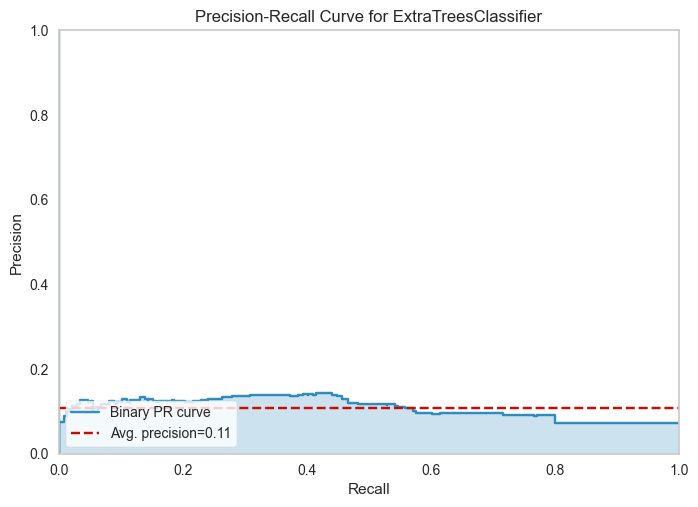

In [66]:
plot_model(modelo_et, plot='pr')

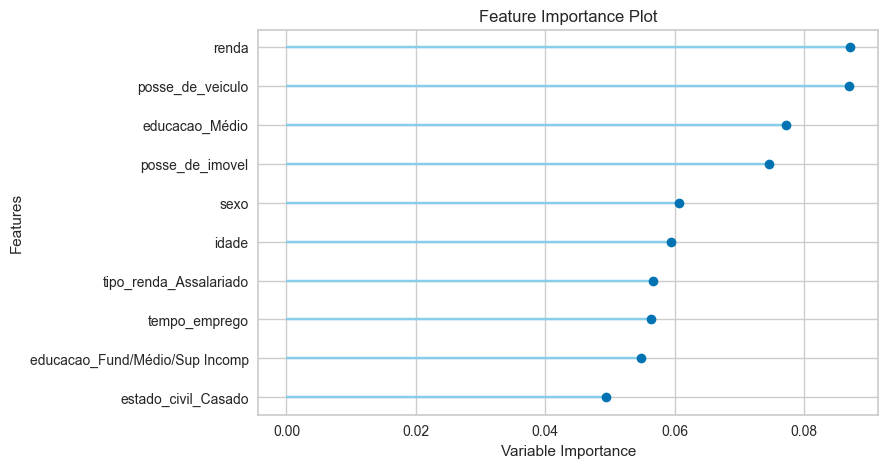

In [67]:
plot_model(modelo_et, plot='feature')

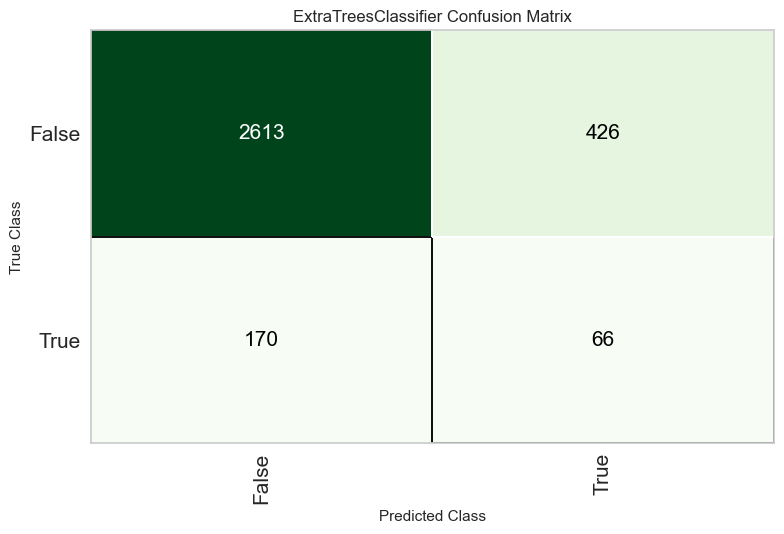

In [68]:
plot_model(modelo_et, plot = 'confusion_matrix')

In [69]:
tuned_modelo_et = tune_model(modelo_et)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9136,0.0000,0.0364,0.1333,0.0571,0.0271,0.0336
1,0.8992,0.0000,0.0545,0.1071,0.0723,0.0249,0.0265
2,0.8560,0.0000,0.2000,0.1429,0.1667,0.0903,0.0918
3,0.8639,0.0000,0.1636,0.1343,0.1475,0.0743,0.0748
4,0.8639,0.0000,0.0545,0.0545,0.0545,-0.0188,-0.0188
5,0.8861,0.0000,0.0545,0.0789,0.0645,0.0060,0.0062
6,0.8325,0.0000,0.2000,0.1158,0.1467,0.0610,0.0639
7,0.8338,0.0000,0.1636,0.1000,0.1241,0.0382,0.0396
8,0.9058,0.0000,0.0000,0.0000,0.0000,-0.0337,-0.0411


Fitting 10 folds for each of 10 candidates, totalling 100 fits


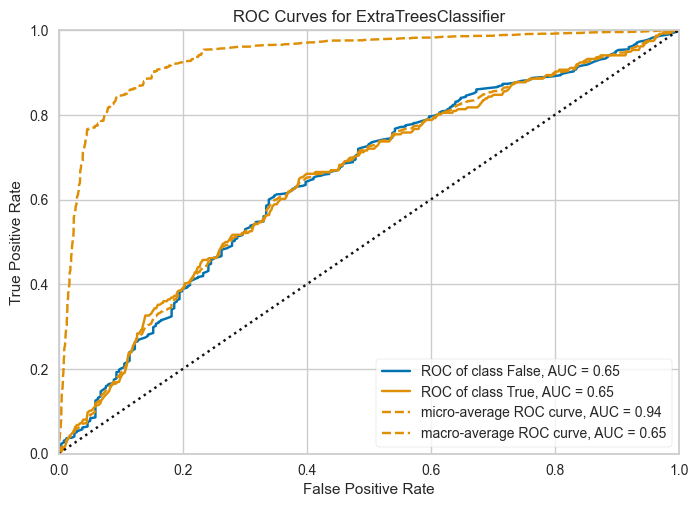

In [70]:
plot_model(tuned_modelo_et, plot='auc')

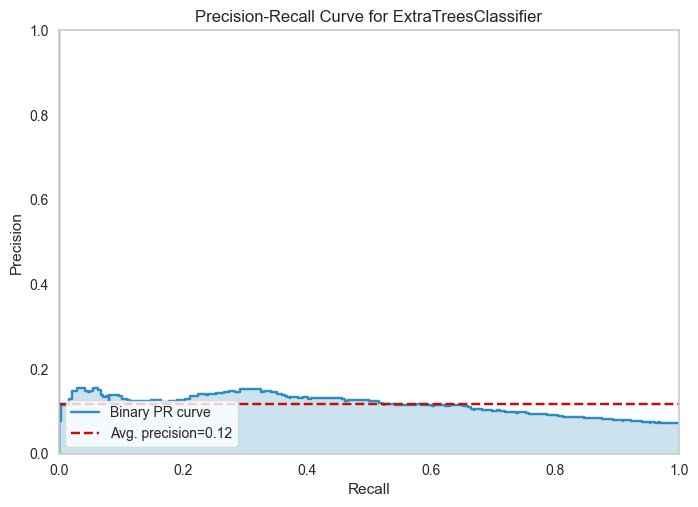

In [71]:
plot_model(tuned_modelo_et, plot='pr')

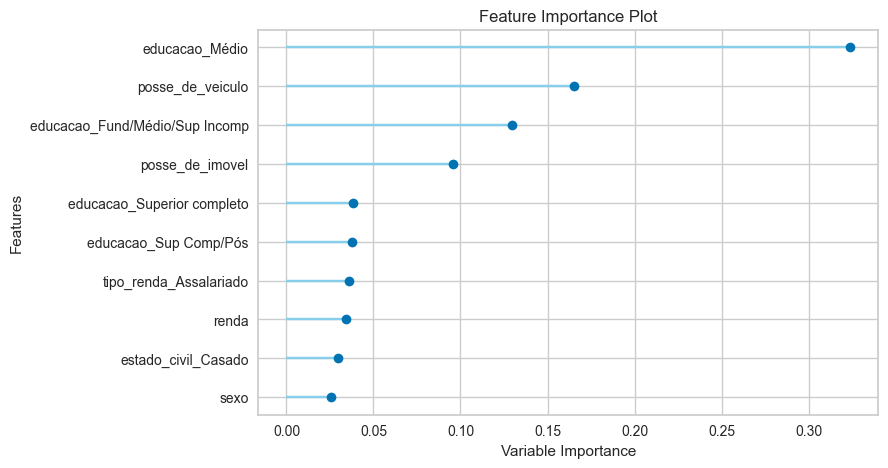

In [72]:
plot_model(tuned_modelo_et, plot='feature')

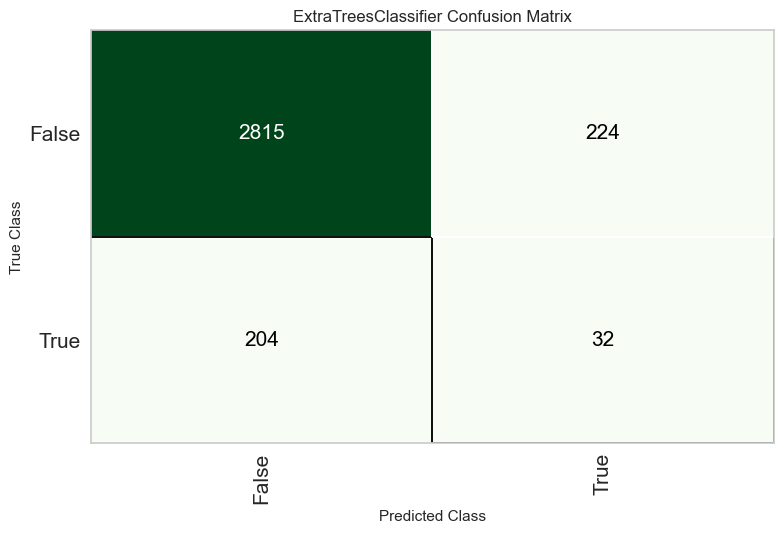

In [73]:
plot_model(tuned_modelo_et, plot='confusion_matrix')

In [74]:
evaluate_model(tuned_modelo_et)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [75]:
predict_model(tuned_modelo_et)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.8693,0.6483,0.1356,0.1250,0.1301,0.0596,0.0596


,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,prediction_label,prediction_score
7639,F,N,N,0,Pensionista,Fund/Médio/Sup Incomp,Viúvo,Casa,59,7.750898,1.0,1690.750000,False,0,0.5131
7640,F,N,S,0,Empresário,Superior completo,Casado,Casa,31,6.852055,2.0,24172.460938,False,0,0.6837
7641,F,N,S,0,Assalariado,Sup Comp/Pós,Viúvo,Casa,58,36.287670,1.0,123193.601562,True,0,0.5826
7642,F,N,S,0,Assalariado,Médio,Casado,Casa,48,18.857534,2.0,501820.843750,False,0,0.7588
7643,M,S,S,0,Assalariado,Médio,Solteiro,Casa,42,1.663014,1.0,5046.089844,False,0,0.7935
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10909,F,N,S,0,Pensionista,Médio,Viúvo,Casa,67,6.367123,1.0,4312.799805,False,0,0.6351
10910,M,S,S,1,Empresário,Médio,Casado,Casa,49,1.857534,3.0,47138.160156,False,0,0.7069
10911,F,N,N,0,Empresário,Superior completo,Casado,Casa,40,5.490411,2.0,10891.009766,False,0,0.5554
10912,F,N,N,0,Pensionista,Fund/Médio/Sup Incomp,Viúvo,Casa,59,7.750898,1.0,1690.750000,True,0,0.5131


In [76]:
final_modelo_et = finalize_model(tuned_modelo_et)

In [77]:
formula = '''
    mau ~  + qtd_filhos + idade + tempo_emprego +  
    qt_pessoas_residencia
'''

rl = smf.glm(formula, data=data, family=sm.families.Binomial()).fit()

rl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Generalized Linear Model Regression Results                      
=======================================================================================
Dep. Variable:     ['mau[False]', 'mau[True]']   No. Observations:                  380
Model:                                     GLM   Df Residuals:                      375
Model Family:                         Binomial   Df Model:                            4
Link Function:                           Logit   Scale:                          1.0000
Method:                                   IRLS   Log-Likelihood:                -91.534
Date:                         Wed, 27 Mar 2024   Deviance:                       183.07
Time:                                 19:59:16   Pearson chi2:                     370.
No. Iterations:                              7   Pseudo R-squ. (CS):            0.04341
Covariance Type:                     nonrobust                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 1.2653      1.171      1.080      0.280      -1.031       3.561
qtd_filhos                0.1074      0.619      0.174      0.862      -1.105       1.320
idade                    -0.0005      0.020     -0.025      0.980      -0.039       0.038
tempo_emprego             0.2293      0.072      3.176      0.001       0.088       0.371
qt_pessoas_residencia     0.0259      0.483      0.054      0.957      -0.920       0.972
=========================================================================================
"""

In [78]:
metadados.sort_values(by='IV', ascending=False)

,dtype,nmissing,valores_unicos,papel,IV
qt_pessoas_residencia,float64,0,9,covariavel,inf
renda,float64,0,112472,covariavel,0.959826
tempo_emprego,float64,0,3005,covariavel,0.283956
idade,int64,0,47,covariavel,0.018434
tipo_renda,object,0,5,covariavel,0.009718
posse_de_imovel,object,0,2,covariavel,0.009690
educacao,object,0,5,covariavel,0.003690
tipo_residencia,object,0,6,covariavel,0.003330
sexo,object,0,2,covariavel,0.002665
qtd_filhos,int64,0,8,covariavel,0.001689


### Salvar o arquivo do modelo treinado

In [79]:
save_model(final_modelo_et,'Best Model Projeto Final 122022')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['qtd_filhos', 'idade',
                                              'tempo_emprego',
                                              'qt_pessoas_residencia', 'renda'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='mean'))),
                 ('categorical_imputer',
                  TransformerWra...
                  ExtraTreesClassifier(bootstrap=True, ccp_alpha=0.0,
                

In [80]:
model_saved = load_model('Best Model Projeto Final 122022')

Transformation Pipeline and Model Successfully Loaded


In [81]:
model_saved.named_steps

{'numerical_imputer': TransformerWrapper(exclude=None,
                    include=['qtd_filhos', 'idade', 'tempo_emprego',
                             'qt_pessoas_residencia', 'renda'],
                    transformer=SimpleImputer(add_indicator=False, copy=True,
                                              fill_value=None,
                                              keep_empty_features=False,
                                              missing_values=nan,
                                              strategy='mean')),
 'categorical_imputer': TransformerWrapper(exclude=None,
                    include=['sexo', 'posse_de_veiculo', 'posse_de_imovel',
                             'tipo_renda', 'educacao', 'estado_civil',
                             'tipo_residencia'],
                    transformer=SimpleImputer(add_indicator=False, copy=True,
                                              fill_value=None,
                                              keep_empty_features=False,
